## VAE analysis of two lung cancer sets

Here we training a VAE of two different datasets within the TCGA. We will first merge the two datasets and subsequently try to separate the samples based on their latent variables. This is made in analogue with the notebook on PCA.

First we retrieve our two TCGA lungcancer data from cbioportal.org. One of the sets are from [Lung Adenocarcinomas](https://en.wikipedia.org/wiki/Adenocarcinoma_of_the_lung) and the other is from [Lung Squamous Cell Carcinomas](https://en.wikipedia.org/wiki/Squamous-cell_carcinoma_of_the_lung). We first load our dataset,  however, I have hiddden the code fort this, as you have seen rthat in previous examples

Particularly, we added code that is hidden in the other version of the notebook,that is not important for the understanding of the analysis, but can be found in the module tcga_read. Execute the code and proceed to next step.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ![ ! -f "dsbook/README.md" ] && git clone https://github.com/statisticalbiotechnology/dsbook.git
    my_path = "dsbook/dsbook/common/"
else:
    my_path = "../common/"
sys.path.append(my_path) # Read local modules for tcga access and qvalue calculations
import load_tcga as tcga

luad = tcga.get_expression_data(my_path + "../data/luad_tcga_pan_can_atlas_2018.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/luad_tcga_pan_can_atlas_2018.tar.gz',"data_mrna_seq_v2_rsem.txt")
lusc = tcga.get_expression_data(my_path + "../data/lusc_tcga_pan_can_atlas_2018.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/lusc_tcga_pan_can_atlas_2018.tar.gz',"data_mrna_seq_v2_rsem.txt")

File extracted to ../data/luad_tcga_pan_can_atlas_2018
File extracted to ../data/lusc_tcga_pan_can_atlas_2018


We now merge the datasets, and see too that we only include transcripts that are measured in all the carcinomas with an count larger than 0. Further we scale the measurements so that every gene expression value is scaled between 0 and 1, using sk-learns [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined = pd.concat([lusc[lusc.index.notna()] , luad[luad.index.notna()]], axis=1, sort=False)
# Drop rows with any missing values
combined.dropna(axis=0, how='any', inplace=True)
combined = combined.loc[~(combined<=0.0).any(axis=1)]
combined.index = combined.index.astype(str)
X=scaler.fit_transform(np.log2(combined).T).T
combined = pd.DataFrame(data=X,index=combined.index,columns=combined.columns)

We are setting up an istance of a machine learning framework, [PyTorch](https://en.wikipedia.org/wiki/PyTorch). It will help us fitting the needed neural network. We also define a dataloader, that will help us load the data for processing in the tensorlibrary, torch.

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import numpy as np

# Setting training parameters
batch_size, lr, epochs, log_interval = 128, 1e-3, 2000, 500
hidden_dim, latent_dim = 64, 12

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(4711)
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

# Convert combined DataFrame to a PyTorch tensor
datapoints = torch.tensor(combined.to_numpy().T, dtype=torch.float32)
labels = torch.tensor([1.0 for _ in lusc.columns] + [0.0 for _ in luad.columns], dtype=torch.float32)

# Use TensorDataset to create a dataset
dataset = TensorDataset(datapoints, labels)

# DataLoader for batching the data
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, **kwargs)


Now we design the VAE. We use an architecure where 13046 features are first throtteled down to 64 features (fc1) then to 2 features, which we predict both mean and variance for (fc21 and fc22).   

We reparametrize those 2 variables, and then expand them to 64 (fc3) and 13046 (fc4) features.
![](img/nn.svg)


In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)       # Input layer of encoder
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # Output layer encoder (mean)
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # Output layer encoder (stdv)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)  # Input layer of decoder
        self.fc4 = nn.Linear(hidden_dim, input_dim)       # Output layer of decoder

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)         # Dividing a logged value by two results in the log of the sqrt of the value 
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h3))
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Next, we next select a gradient descent optimizer, [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam), and select a fuction to optimize, the loss_function, and we define a train and test procedure to use.

In [5]:
input_dim = combined.shape[0]
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # Calculating the Kullback–Leibler divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(f"BCE={BCE}, KLD={KLD}")
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    if epoch % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
#        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    if epoch % log_interval == 0:
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


Now we are set to run the procedure for 2000 epochs.

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
test(epoch)

Train Epoch: 500 [0/994 (0%)]	Loss: 8625.100586
Train Epoch: 500 [128/994 (12%)]	Loss: 8602.254883
Train Epoch: 500 [256/994 (25%)]	Loss: 8608.509766
Train Epoch: 500 [384/994 (38%)]	Loss: 8629.704102
Train Epoch: 500 [512/994 (50%)]	Loss: 8623.093750
Train Epoch: 500 [640/994 (62%)]	Loss: 8606.712891
Train Epoch: 500 [768/994 (75%)]	Loss: 8612.169922
Train Epoch: 500 [686/994 (88%)]	Loss: 8606.663903
====> Epoch: 500 Average loss: 8614.5060
Train Epoch: 1000 [0/994 (0%)]	Loss: 8613.653320
Train Epoch: 1000 [128/994 (12%)]	Loss: 8609.118164
Train Epoch: 1000 [256/994 (25%)]	Loss: 8605.368164
Train Epoch: 1000 [384/994 (38%)]	Loss: 8624.389648
Train Epoch: 1000 [512/994 (50%)]	Loss: 8584.883789
Train Epoch: 1000 [640/994 (62%)]	Loss: 8595.599609
Train Epoch: 1000 [768/994 (75%)]	Loss: 8625.172852
Train Epoch: 1000 [686/994 (88%)]	Loss: 8587.384566
====> Epoch: 1000 Average loss: 8606.2489
Train Epoch: 1500 [0/994 (0%)]	Loss: 8601.932617
Train Epoch: 1500 [128/994 (12%)]	Loss: 8595.67089

Note that we for this dataset have chosen to not use an independent testset. We have now trained our VAE. We can first evaluate it for the datapoints we trained it on, and get their embeddings in a vector, $y$.

In [7]:
model.eval()

x_batch, z_batch, std_batch = [], [], []
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.to(device)

        x_hat_, mean_, log_var = model(x)
        x_batch.append(x_hat_.cpu().detach().numpy())
        z_batch.append(mean_.cpu().detach().numpy())
        std_batch.append(torch.exp(log_var * 0.5).cpu().detach().numpy())

x_hat = np.concatenate(x_batch, axis=0)
z = np.concatenate(z_batch, axis=0)
std = np.concatenate(std_batch, axis=0)

We can now use the embeddings to describe our data. We first plot the differeces between the different latent variables for the different datasets

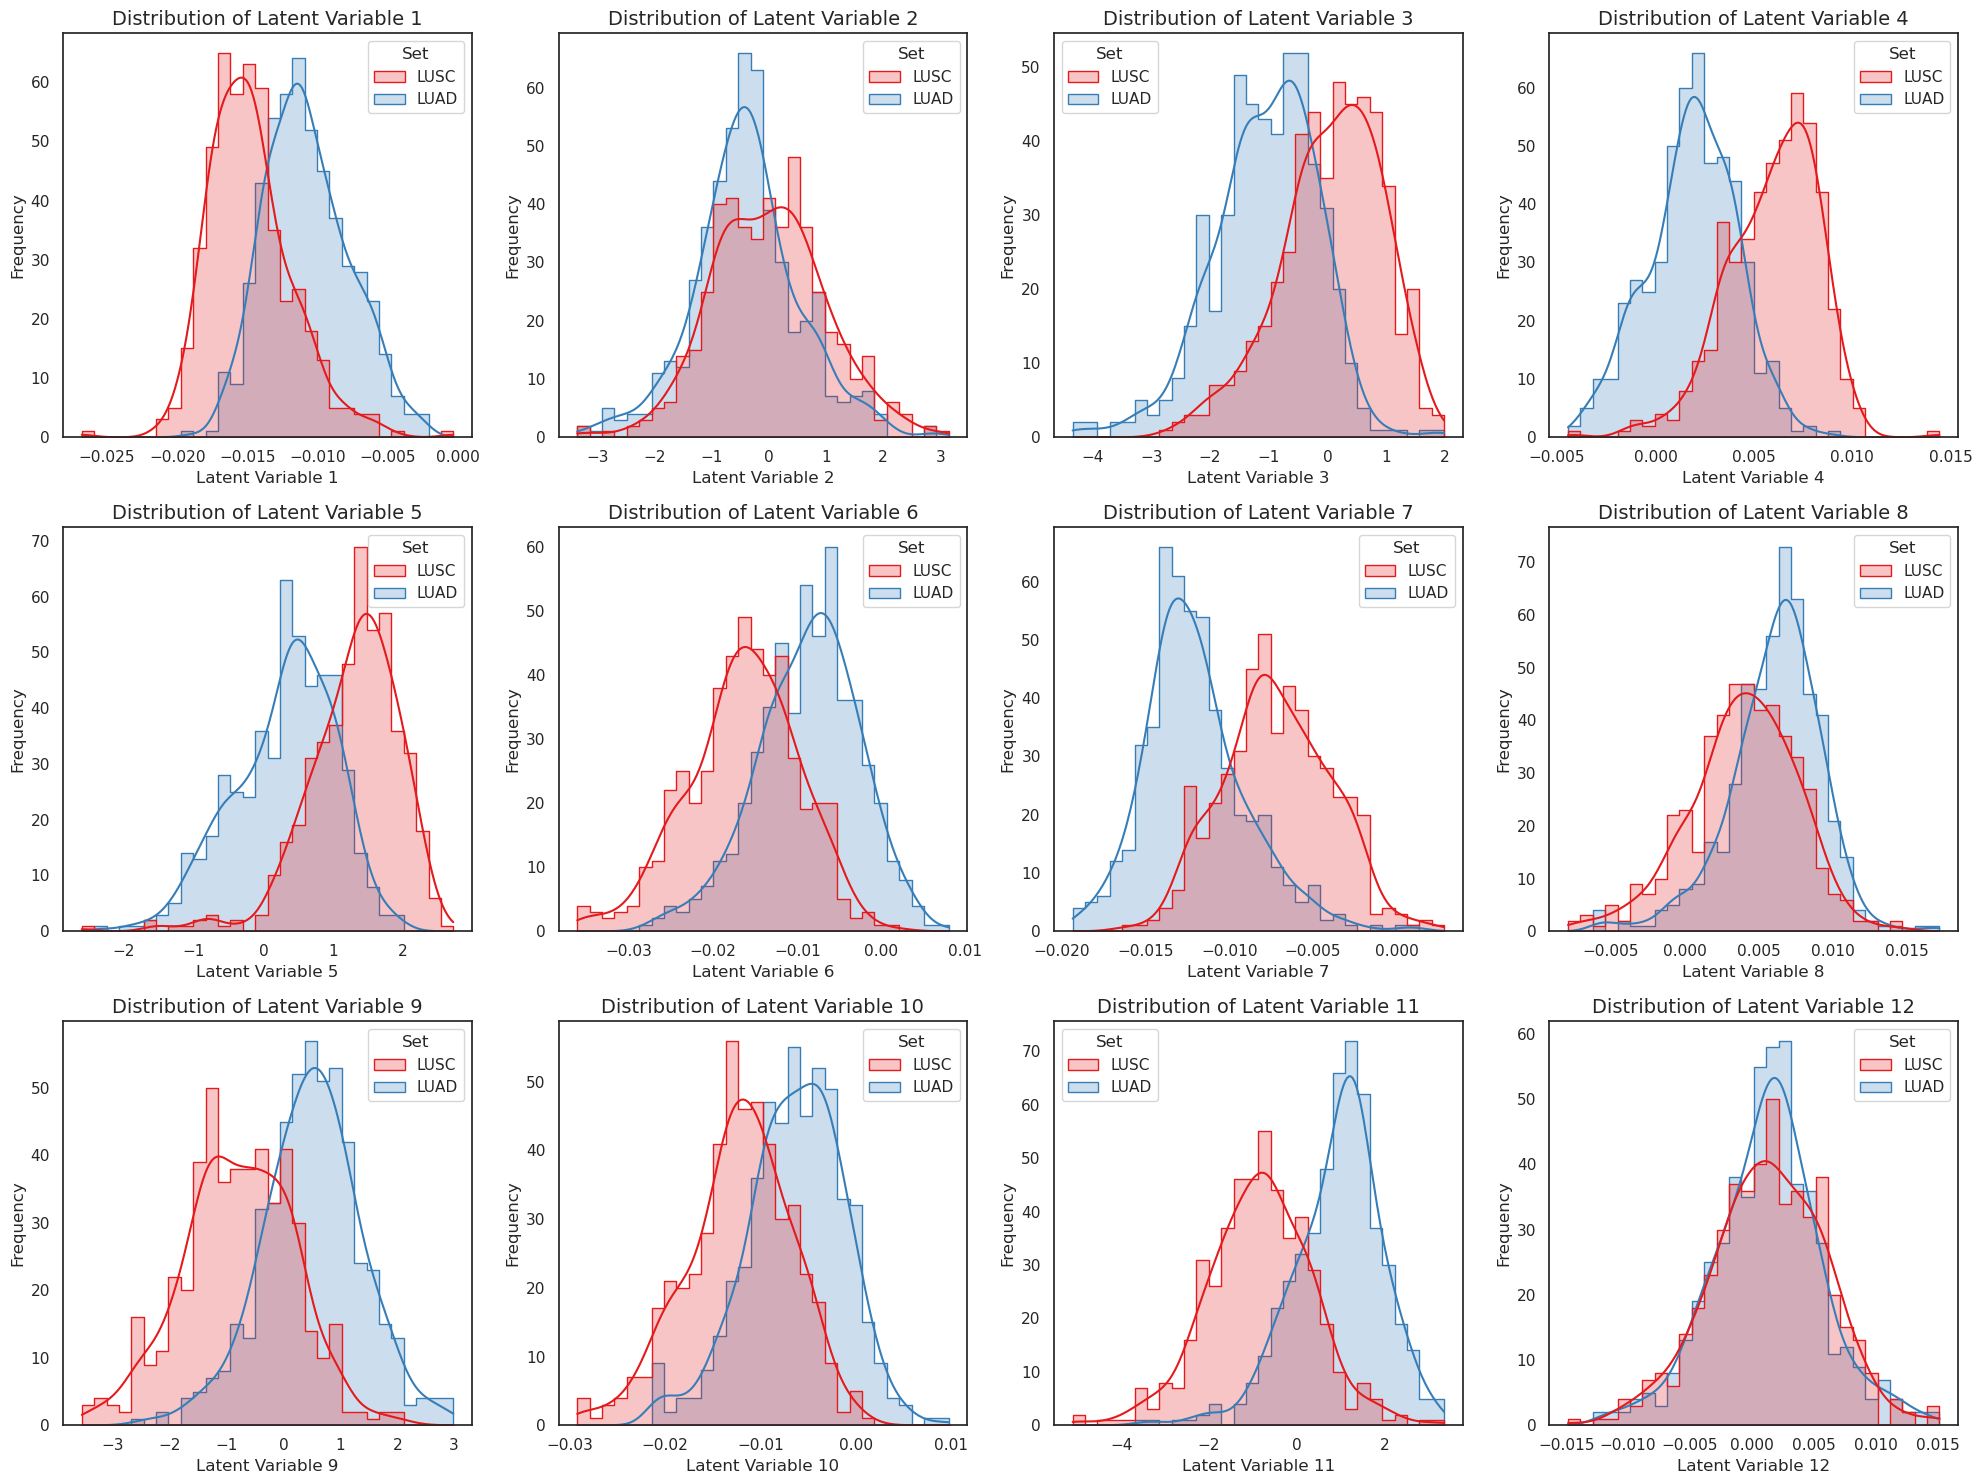

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create DataFrame for transformed patients
transformed_patients = pd.DataFrame(
    data=z,
    columns=[f"Latent Variable {ix+1}" for ix in range(latent_dim)],
    index=list(lusc.columns) + list(luad.columns)
)
transformed_patients["Set"] = ["LUSC" for _ in lusc.columns] + ["LUAD" for _ in luad.columns]

# Set Seaborn plotting style
sns.set(style="white", rc={"axes.titlesize": 14, "axes.labelsize": 12})

# Determine grid size
plots_per_row = 4
n_rows = int(np.ceil(latent_dim / plots_per_row))

# Create subplots
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Plot each latent variable's histogram
for i in range(latent_dim):
    latent_variable_name = f"Latent Variable {i+1}"
    sns.histplot(
        data=transformed_patients,
        x=latent_variable_name,
        hue="Set",
        kde=True,
        element="step",
        bins=30,
        palette="Set1",
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {latent_variable_name}")
    axes[i].set_xlabel(latent_variable_name)
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots if latent_dim is not divisible by plots_per_row
for j in range(latent_dim, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We see that variables 4 and 7 seem to include most of the differences beteen the sets.
Much like for the PCA we can use the embeddings to give a dimentionallity reduced description of each cancer's expression profile using those two variables. 

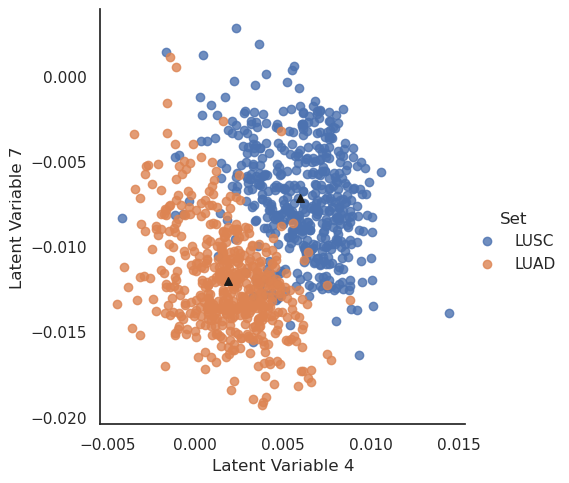

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
transformed_patients = pd.DataFrame(data=z,columns=[f"Latent Variable {ix+1}" for ix in range(latent_dim)],index=list(lusc.columns) + list(luad.columns))
transformed_patients["Set"]= (["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns])

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
#sns.set_context("talk")

lm = sns.lmplot(x="Latent Variable 4",y="Latent Variable 7", hue='Set', data=transformed_patients, fit_reg=False)
#for x, y, (w, h) in zip(transformed_patients["Latent Variable 1"], transformed_patients["Latent Variable 2"], std):
#    lm.axes[0, 0].add_patch(Ellipse((x,y), w, h, fc='#CCCCCC', lw=1, alpha=0.5, zorder=1))
means={}
for name,set_ in transformed_patients.groupby("Set"):
    means[name] = set_.mean(numeric_only=True).to_numpy()
    plt.scatter(means[name][4-1],means[name][7-1], marker='^',s=30,c='k')

Here we see a quite good, but not perfect separation of the patients based on two latent variables.

## Using the Decoder for generating example data

Furter, we can use the network to generate "typical" expression profiles. We have marked the means of each sample with black triangles. We will now take these mean values of each patient group and use them as representation of each cancer type, and feed these two values for each patient group to the VAE's decoder.

In [10]:
z_fix = torch.tensor(np.concatenate(([means["LUSC"]],[means["LUAD"]]), axis=0))

z_fix = z_fix.to(device)
x_fix = model.decode(z_fix).cpu().detach().numpy()
predicted = pd.DataFrame(data=x_fix.T, index=combined.index, columns=["LUSC", "LUAD"])

Using these generated profiles we may for instance identify the genes most differential between the generated LUSC and LUAD sample. 

In [11]:
predicted["diff"] = predicted["LUSC"] - predicted["LUAD"]
# predicted.sort_values(by='diff', ascending=False, inplace = True)

The genes that the dencoder find most different between the set means  can now be identified. First the gene lwith largest difference between the LUSC and LUAD in positive direction:

In [12]:
predicted["diff"].idxmin(axis=0)

'GNA14'

and then in negative direction (larger in LUAD than LUSC). 

In [13]:
predicted["diff"].idxmax(axis=0)

'C9orf125'

Here these two genes seems to be the largest differentiators beteen the genes in LUSC and LUAD. We can also note that as with PCA, the Gene KRT17 seems quite different between the cancer types:

In [14]:
predicted.loc["KRT17"]

LUSC    0.808518
LUAD    0.410448
diff    0.398070
Name: KRT17, dtype: float32

In [15]:
# transformed_patients[transformed_patients["Set"]=="LUSC"][transformed_patients["Latent Variable 2"] < -4.]